# Model evaluation code
This code imports and checks the trained agent, and creates an assortment of plots

In [9]:
import matplotlib.pyplot as plt

import pandas as pd

#import gym
import numpy as np
from stable_baselines3 import A2C, DDPG, SAC, PPO, TD3
from matplotlib import axis
#import numpy as np
from floris.tools import FlorisInterface
#from floris.tools.visualization import visualize_cut_plane

#import matplotlib.pyplot as plt
#from floris.tools.optimization.yaw_optimization.yaw_optimizer_sr import YawOptimizationSR

#Importing custom environment.
from Custom_functions import CustomEnv, CustomEnv2
import copy

import seaborn as sns
from scipy import stats
import tensorboard as tb

Choose the name of the model you want to test:

In [417]:
import os

class model_eval:
    def __init__(self, model_name, excel_path = r'models\Overview.xlsx'):

        self.model_name = model_name
        self.excel_path = excel_path

        self.init_env()


        files = os.listdir("models/"+self.model_name)

        numbers = []
        for file in files:
            numbers.append(file.split(".")[0])
        self.model_steps = np.array(numbers, dtype =  np.int32)


    def load_models(self, n_models):
        n_models = np.array([n_models]).flatten()

        self.models = []

        for models in n_models:

            #check if the selected model is saved. If not raise error:
            if models not in self.model_steps:
                raise Exception("You can select a model that is not saved") 

            model_path = "models/"+self.model_name+"/"+str(models)


            if self.Model_name[0:3] == "PPO":
                model = PPO.load(model_path, env=self.env)
                #print("PPO model loaded")
            if self.Model_name[0:3] == "A2C":
                model = A2C.load(model_path, env=self.env)
                #print("A2C model loaded")
            if self.Model_name[0:3] == "SAC":
                model = SAC.load(model_path, env=self.env)
                #print("SAC model loaded")
            if self.Model_name[0:3] == "TD3":
                model = TD3.load(model_path, env=self.env)
                #print("TD3 model loaded")

            self.models.append(model)
        self.model_n = n_models

    def see_models(self):

        indic = np.array(self.model_steps, dtype=np.int32).argsort()

        files_sorted = []
        for i in indic:
            files_sorted.append(files[i])

        self.files_sorted = files_sorted

        print("Avaliable models are:")
        i = 0
        for files in self.files_sorted:
            print(i, " | " ,files)
            i +=1

        
    def see_tb(self):
        #This function plots the tensorboard log for the run

        experiment = tb.data.experimental.ExperimentFromDev("KUZYeA4JRAiOyXBwDujBcA")
        
        df = experiment.get_scalars()

        ind_run = df.index[df['run'] == self.model_name + "_0"].tolist()

        sliced_df = df[ind_run[0]:ind_run[-1]]

        ind_rew = sliced_df.index[sliced_df['tag'] == 'rollout/ep_rew_mean'].tolist()

        tb_step = df[ind_rew[0]:ind_rew[-1]]["step"].to_numpy()
        tb_val = df[ind_rew[0]:ind_rew[-1]]["value"].to_numpy()

        plt.plot(tb_step, tb_val)
        plt.xlabel("Step")
        plt.ylabel("Reward")
        plt.grid()
        plt.xticks(np.arange(0, 500_000, step=25_000), rotation = 45)  # Set label locations.
        [plt.axvline(_x, linestyle = "--", linewidth = 0.5, color = "grey") for _x in self.model_steps]
        plt.show()

    def eval_agent(self):

        self.agent_actions = np.zeros((len(self.models), len(range(self.wd_min, self.wd_max+1)), self.nx * self.ny ))
        self.baseline_power = np.zeros((len(self.models), len(range(self.wd_min, self.wd_max+1))))
        self.agent_powers = np.zeros((len(self.models), len(range(self.wd_min, self.wd_max+1))))
        self.wind_dirs = np.zeros((len(self.models), len(range(self.wd_min, self.wd_max+1))))

        i = 0
        for model in self.models:
            
            print(model)

            TI = self.TI_min
            agent_actions = []
            agent_power = []
            baseline_power = []
            wind_dirs = []

            yaw_angles = np.zeros((1, 1, self.nx*self.ny)) 
            yaw_zero = np.zeros((1, 1, self.nx*self.ny)) 

            wind_speed = 7

            ws_norm = (wind_speed - self.env.ws_range_min)/(self.env.ws_range_max - self.env.ws_range_min)
            TI_norm = (TI - self.env.ti_range_min)/(self.env.ti_range_max - self.env.ti_range_min)  


            for wind_dir in range(self.wd_min, self.wd_max+1):
                wind_dirs.append(wind_dir)
                wd_norm = (wind_dir - self.env.wd_range_min)/(self.env.wd_range_max - self.env.wd_range_min)

                observation = np.array([wd_norm, ws_norm, TI_norm], dtype = np.float32)
                action, _states = model.predict(observation, deterministic=True)
                
                action = action*self.env.yaw_max   #scales the action to the 
                agent_actions.append(action)
                
                self.fi.reinitialize(
                    wind_directions=[wind_dir],
                    turbulence_intensity= TI,
                    wind_speeds=[wind_speed]
                    )
                
                yaw_angles[0,0,:] = action
                self.fi.calculate_wake(yaw_angles = yaw_zero)
                
                baseline_power.append(self.fi.get_farm_power()[0][0])
                
                self.fi.calculate_wake(yaw_angles = yaw_angles)
                agent_power.append(self.fi.get_farm_power()[0][0])
                
            agent_actions = np.array(agent_actions)
            baseline_power = np.array(baseline_power)
            agent_power = np.array(agent_power)
            wind_dirs = np.array(wind_dirs)


            self.agent_actions[i,:,:] = agent_actions
            self.baseline_power[i,:] = baseline_power
            self.agent_powers[i,:] = agent_power
            self.wind_dirs[i,:] = wind_dirs
            i =  i + 1
            print("run number:", i, "done")

        print("All done")

    def eval_rewards(self):

        self.agent_rewards = np.zeros( (len(self.models), self.env.t_max + 1 )  )
        self.sim_wd = np.zeros( (len(self.models), self.env.t_max + 1 )  )

        i = 0
        for model in self.models:
            obs_wd = []
            obs_ws = []
            obs_ti = []
            rew = []
            reward = 0
            obs = self.env.reset()
            done = False
            while not done:
                action, _states = model.predict(obs, deterministic=True)
                obs, rewards, done, info = self.env.step(action)
                reward = reward + rewards
                obs_wd.append(obs[0])
                obs_ws.append(obs[1])
                obs_ti.append(obs[2])
                rew.append(rewards)

            obs_wd = np.array(obs_wd)
            obs_ws = np.array(obs_ws)
            obs_ti = np.array(obs_ti)
            rew    = np.array(rew)

            wd_scaled = obs_wd*(self.env.wd_range_max - self.env.wd_range_min) + self.env.wd_range_min
            ws_scaled = obs_ws*(self.env.ws_range_max - self.env.ws_range_min) + self.env.ws_range_min
            ti_scaled = obs_ti*(self.env.ti_range_max - self.env.ti_range_min) + self.env.ti_range_min

            self.agent_rewards[i,:] = rew
            self.sim_wd[i,:] = wd_scaled
            i += 1

    def plot_reward(self):

        rows = len(self.models)

        fig1, axs1 = plt.subplots(nrows=rows, ncols=1, figsize=(10, 7))
        plt.subplots_adjust(hspace=0.5)
        fig1.suptitle("Cumulative reward", fontsize=18, y=0.95)

        for i in range(rows):
            axs1[i].plot(np.cumsum(self.agent_rewards[i,:]))

            axs1[i].set_ylabel("cumulative reward")
            axs1[i].set_xlabel("simulation")
            axs1[i].set_title(label = str(self.model_n[i]))
            axs1[i].grid()

        plt.show()

    def plot_reward2(self):

        rows = len(self.models)
        fig2, axs2 = plt.subplots(nrows=rows, ncols=1, figsize=(10, 7))
        plt.subplots_adjust(hspace=0.5)
        fig2.suptitle("Reward pr. wind direction", fontsize=18, y=0.95)

        for i in range(rows):

            sort_ind = self.sim_wd[i,:].argsort()
            wd_temp = self.sim_wd[i,:]
            rew_temp = self.agent_rewards[i,:]

            wd_sorted = wd_temp[sort_ind[::-1]]
            rew_sorted = rew_temp[sort_ind[::-1]]



            axs2[i].plot(wd_sorted, rew_sorted)

            axs2[i].set_ylabel("reward")
            axs2[i].set_xlabel("Wind direction [deg]")
            axs2[i].set_title(label = str(self.model_n[i]))
            axs2[i].grid()

        #plt.legend()
        plt.show()

    def plot_power(self):
        
        rows = len(self.models)

        fig, axs = plt.subplots(nrows=rows, ncols=1, figsize=(10, 7))
        plt.subplots_adjust(hspace=0.5)
        fig.suptitle("Model evaluation plot", fontsize=18, y=0.95)

        for i in range(rows):
            axs[i].plot(self.wind_dirs[i,:], self.agent_powers[i,:], label = "Agent farm power output")
            axs[i].plot(self.wind_dirs[i,:], self.baseline_power[i,:], label = "Baseline power output")

            axs[i].set_ylabel("Power output [W]")
            axs[i].set_xlabel("Wind direction [W]")
            axs[i].set_title(label = str(self.model_n[i]))


        # plt.ylabel('Power output [W]')
        # plt.xlabel('Wind direction')
        plt.legend()
        plt.show()

    def init_env(self):
        #This initialized the environment.

        df = pd.read_excel (self.excel_path)
        self.index = df[df["Model name"]==self.model_name].index.values[0]

        self.Model_name = df["Model name"][self.index]
        t_steps = df["t_steps"][self.index]
        dist = df["dist"][self.index]
        self.nx = df["nx"][self.index]
        self.ny = df["ny"][self.index]
        turb_type = df["turb_type"][self.index]
        combination = df["combination"][self.index]
        deflection = df["deflection"][self.index]
        turbulence = df["turbulence"][self.index]
        velocity = df["velocity"][self.index]
        self.WS_min = df["WS_min"][self.index]
        self.WS_max = df["WS_max"][self.index]
        self.TI_min = df["TI_min"][self.index]
        self.TI_max = df["TI_max"][self.index]
        self.wd_min = df["wd_min"][self.index]
        self.wd_max = df["wd_max"][self.index]
        self.yaw_max = df["yaw_max"][self.index]
        rho = df["rho"][self.index]

        self.env = CustomEnv2(t_steps, dist, self.nx, self.ny, turb_type, combination, deflection,
                    turbulence, velocity, self.WS_min, self.WS_max, self.TI_min, self.TI_max, self.wd_min, self.wd_max, 
               self.yaw_max, rho)

        print("Env initialized")

        #Initializes floris

        fi = FlorisInterface("gch.yaml")   

        #Turns it into a dictionary and then does the changes to the model
        fi_dict = fi.floris.as_dict()

        fi_dict["farm"]["turbine_type"]                       = [turb_type]
        fi_dict["wake"]["model_strings"]["combination_model"] = combination
        fi_dict["wake"]["model_strings"]["deflection_model"]  = deflection
        fi_dict["wake"]["model_strings"]["turbulence_model"]  = turbulence
        fi_dict["wake"]["model_strings"]["velocity_model"]    = velocity
        fi_dict["flow_field"]["air_density"]                  = rho

        # Turns it back into a floris object:
        self.fi = FlorisInterface(fi_dict)

        D = self.fi.floris.farm.rotor_diameters[0]

        x = np.linspace(0, D*dist*self.nx, self.nx)
        y = np.linspace(0, D*dist*self.ny, self.ny)

        xv, yv = np.meshgrid(x, y, indexing='xy')

        self.layout_x =  xv.flatten()
        self.layout_y = yv.flatten()

        self.fi.reinitialize(
                    layout=(self.layout_x, self.layout_y),
                    )
        print("Floris initialized")


    

Env initialized
Floris initialized
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
eval begin
run number: 1 done
run number: 2 done
All done


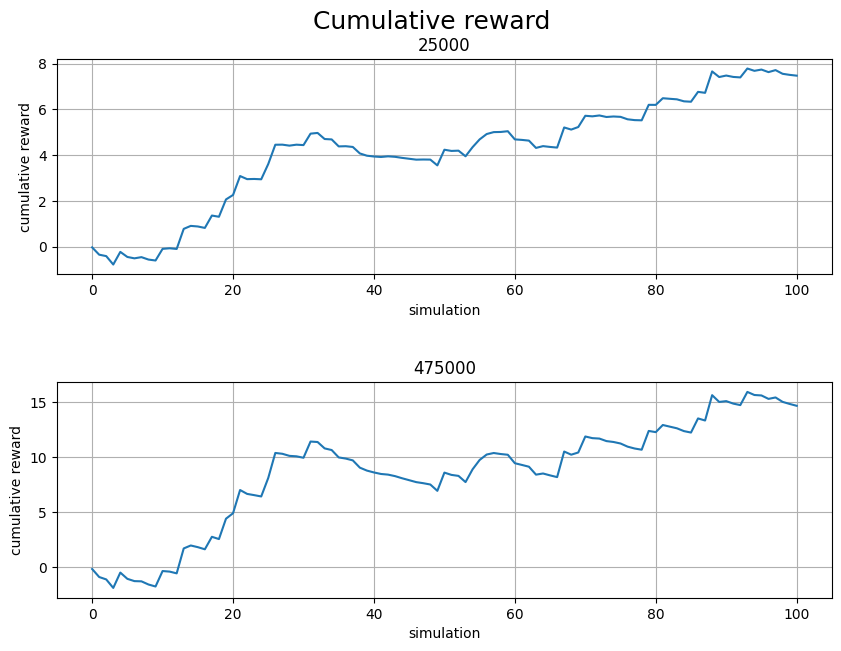

In [418]:
A = np.array([25000, 475000])
test = model_eval("A2C5")
test.load_models(A)
print("eval begin")
test.eval_agent()
#test.plot_power()
test.eval_rewards()
test.plot_reward()


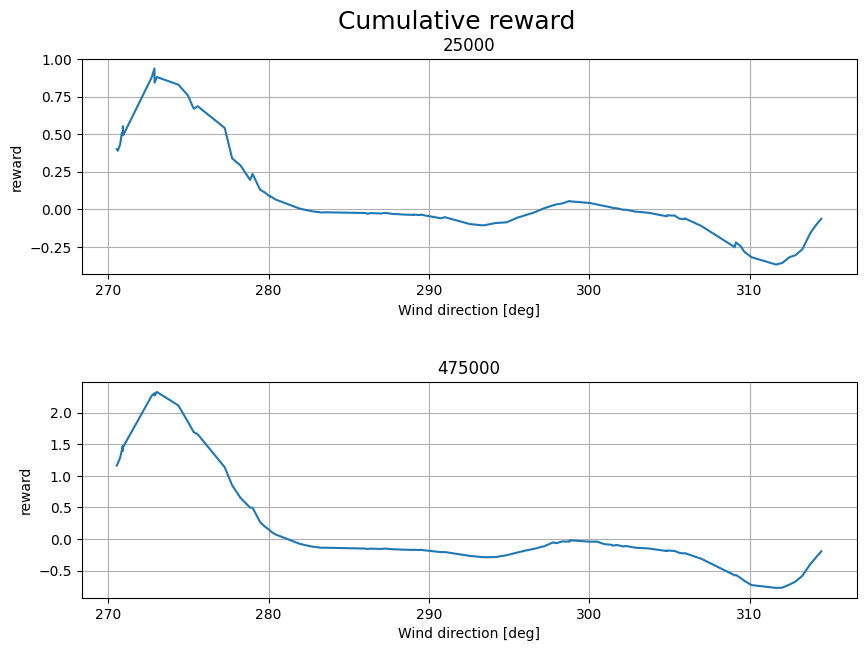

In [419]:
test.plot_reward2()

This then sets up the environment, according to the test document 

Then we load either PPO or A2C model:

Creates Floris class

Does the simulations for the wind directions 

In [14]:
TI = TI_min

actions = []
agent_power = []
baseline_power = []
wind_dirs = []
yaw_angles = np.zeros((1, 1, nx*ny)) 
yaw_zero = np.zeros((1, 1, nx*ny)) 

wind_speed = 7



ws_norm = (wind_speed - env.ws_range_min)/(env.ws_range_max - env.ws_range_min)
TI_norm = (TI - env.ti_range_min)/(env.ti_range_max - env.ti_range_min)  


for wind_dir in range(wd_min, wd_max+1):
    wind_dirs.append(wind_dir)
    wd_norm = (wind_dir - env.wd_range_min)/(env.wd_range_max - env.wd_range_min)
    #observation = np.array([self.wd_norm, self.ws_norm, self.TI_norm], dtype = np.float32)
    observation = np.array([wd_norm, ws_norm, TI_norm], dtype = np.float32)

    action, _states = model.predict(observation, deterministic=True)
    
    action = action*env.yaw_max   #scales the action to the 
    actions.append(action)
    
    fi.reinitialize(
        wind_directions=[wind_dir],
        turbulence_intensity= TI,
        wind_speeds=[wind_speed]
        )
    
    yaw_angles[0,0,:] = action
    fi.calculate_wake(yaw_angles = yaw_zero)
    
    baseline_power.append(fi.get_farm_power()[0][0])
    
    fi.calculate_wake(yaw_angles = yaw_angles)
    agent_power.append(fi.get_farm_power()[0][0])
        
        

actions = np.array(actions)
np.unique(actions,axis = 0)

baseline_power = np.array(baseline_power)
agent_power = np.array(agent_power)
wind_dirs = np.array(wind_dirs)

print("done")

done


In [15]:
print("The wind direction and the yaw angles are:")
for i in range(len(actions)):
    
    print(f"Wind dir: {wind_dirs[i]:.2f}|T 1:{actions[i,0]:.2f}|T 2:{actions[i,1]:.2f}|T 3:{actions[i,2]:.2f}|T 4:{actions[i,3]:.2f}|T 5:{actions[i,4]:.2f}|T 6:{actions[i,5]:.2f}|T 7:{actions[i,6]:.2f}|T 8:{actions[i,7]:.2f}|T 9:{actions[i,8]:.2f}")

    

The wind direction and the yaw angles are:
Wind dir: 270.00|T 1:3.95|T 2:4.42|T 3:-0.14|T 4:1.87|T 5:1.95|T 6:0.80|T 7:0.55|T 8:2.20|T 9:-0.82
Wind dir: 271.00|T 1:3.96|T 2:4.42|T 3:-0.15|T 4:1.87|T 5:1.95|T 6:0.80|T 7:0.55|T 8:2.21|T 9:-0.83
Wind dir: 272.00|T 1:3.96|T 2:4.43|T 3:-0.15|T 4:1.86|T 5:1.96|T 6:0.80|T 7:0.55|T 8:2.22|T 9:-0.84
Wind dir: 273.00|T 1:3.97|T 2:4.43|T 3:-0.15|T 4:1.85|T 5:1.96|T 6:0.81|T 7:0.55|T 8:2.23|T 9:-0.85
Wind dir: 274.00|T 1:3.98|T 2:4.44|T 3:-0.15|T 4:1.84|T 5:1.96|T 6:0.81|T 7:0.55|T 8:2.23|T 9:-0.86
Wind dir: 275.00|T 1:3.98|T 2:4.44|T 3:-0.16|T 4:1.84|T 5:1.96|T 6:0.81|T 7:0.56|T 8:2.24|T 9:-0.86
Wind dir: 276.00|T 1:3.99|T 2:4.44|T 3:-0.16|T 4:1.83|T 5:1.96|T 6:0.81|T 7:0.56|T 8:2.25|T 9:-0.87
Wind dir: 277.00|T 1:3.99|T 2:4.45|T 3:-0.16|T 4:1.82|T 5:1.97|T 6:0.81|T 7:0.56|T 8:2.26|T 9:-0.88
Wind dir: 278.00|T 1:4.00|T 2:4.45|T 3:-0.16|T 4:1.81|T 5:1.97|T 6:0.81|T 7:0.56|T 8:2.26|T 9:-0.89
Wind dir: 279.00|T 1:4.01|T 2:4.46|T 3:-0.17|T 4:1.80|T 5

In [376]:
x = np.array([20, 10, 5, 10])

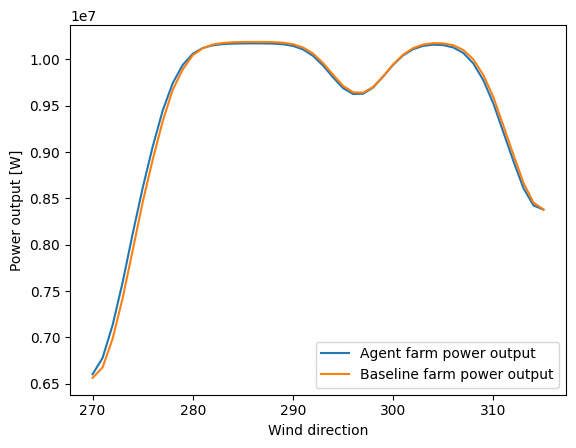

In [17]:
#Plots the power outputs

plt.plot(wind_dirs, agent_power, label = "Agent farm power output")
plt.plot(wind_dirs, baseline_power, label = "Baseline farm power output")
plt.ylabel('Power output [W]')
plt.xlabel('Wind direction')
plt.legend()
plt.show()

In [406]:
env.t_max + 1

101

In [404]:
len(wd_scaled)

101

In [18]:
obs_wd = []
obs_ws = []
obs_ti = []
rew = []
reward = 0
obs = env.reset()
i = 0
done = False
while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, rewards, done, info = env.step(action)
    reward = reward + rewards
    obs_wd.append(obs[0])
    obs_ws.append(obs[1])
    obs_ti.append(obs[2])
    rew.append(rewards)
    print(done, i, rewards)
    i += 1
print("total reward:", reward)

obs_wd = np.array(obs_wd)
obs_ws = np.array(obs_ws)
obs_ti = np.array(obs_ti)
rew    = np.array(rew)

wd_scaled = obs_wd*(env.wd_range_max - env.wd_range_min) + env.wd_range_min
ws_scaled = obs_ws*(env.ws_range_max - env.ws_range_min) + env.ws_range_min
ti_scaled = obs_ti*(env.ti_range_max - env.ti_range_min) + env.ti_range_min


plt.plot(np.cumsum(rew))
plt.xlabel("simulation")
plt.ylabel("cumulative reward")
plt.show()


False 0 -0.17284872120081068
False 1 -0.7291383900880525
False 2 -0.2191691697108245
False 3 -0.7737091164480393
False 4 1.3967761999641186
False 5 -0.5697854103744693
False 6 -0.2077383696331213
False 7 -0.020356731748474376
False 8 -0.2880373606720728
False 9 -0.18143919675881448
False 10 1.406535622706243
False 11 -0.051836433589626404
False 12 -0.1588413722399925
False 13 2.2674915784539134
False 14 0.2680955404038668
False 15 -0.15198901995930797
False 16 -0.19385091124554843
False 17 1.1363037810524284
False 18 -0.2058750959536781
False 19 1.853093581874635
False 20 0.49638771211728194
False 21 2.112731772808727
False 22 -0.35338635449846917
False 23 -0.1119728203075391
False 24 -0.12047727659892493
False 25 1.688398835173234
False 26 2.2702916929798644
False 27 -0.07637767993612764
False 28 -0.18816153822211618
False 29 -0.04261657923244886
False 30 -0.13051625228054306
False 31 1.4744516382078359
False 32 -0.04177200065415999
False 33 -0.5804049117401788
False 34 -0.15000186750

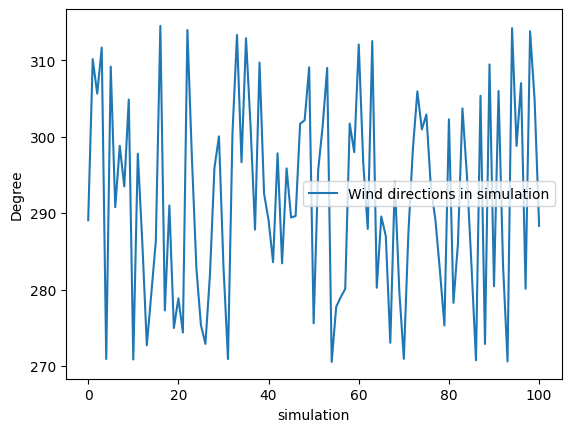

In [21]:
plt.plot(wd_scaled, label = "Wind directions in simulation")
plt.ylabel('Degree')
plt.xlabel('simulation')
plt.legend()
plt.show()

(array([12.,  9., 14.,  7.,  9., 10., 10., 12.,  8., 10.]),
 array([270.52713, 274.9221 , 279.31708, 283.71204, 288.107  , 292.50195,
        296.89694, 301.2919 , 305.68686, 310.08185, 314.4768 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

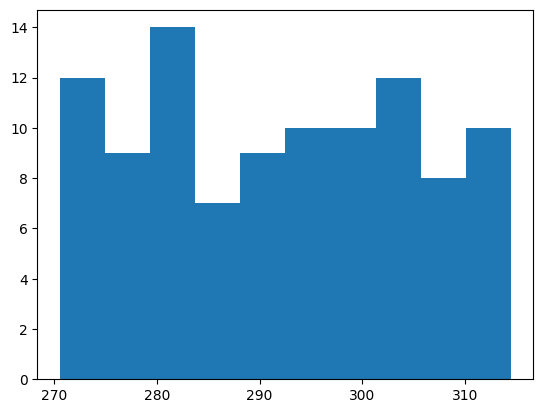

In [22]:
plt.hist(wd_scaled)

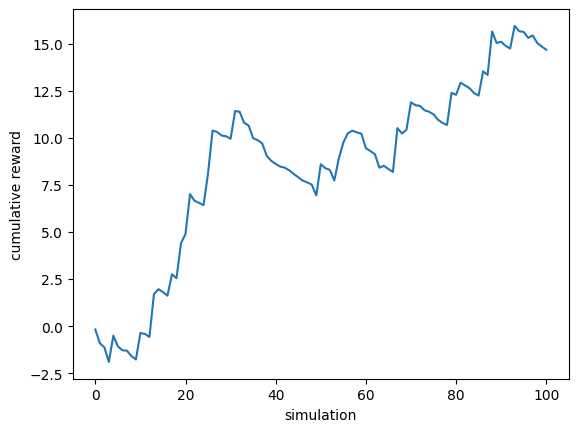

In [24]:
plt.plot(np.cumsum(rew))
plt.xlabel("simulation")
plt.ylabel("cumulative reward")
plt.show()

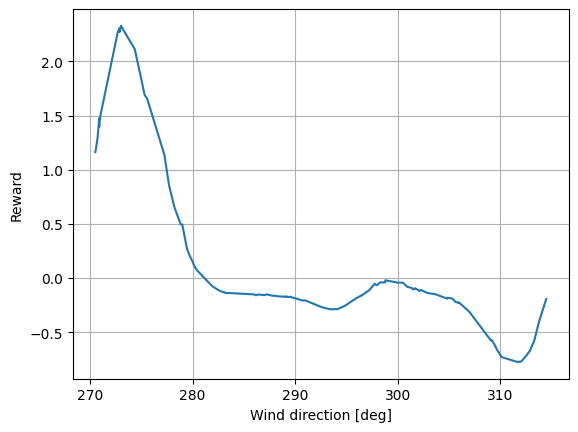

In [31]:
sort_ind = wd_scaled.argsort()
wd_sorted = wd_scaled[sort_ind[::-1]]
rew_sorted = rew[sort_ind[::-1]]

plt.plot(wd_sorted,rew_sorted)

plt.ylabel("Reward")
plt.xlabel("Wind direction [deg]")
plt.grid()
plt.show()

In [117]:
tensorboard dev upload --logdir logs/A2C4_0

UsageError: Line magic function `%tensorboard` not found.


,run,tag,step,value
0,A2C4_0,rollout/ep_len_mean,1000,95.444443
1,A2C4_0,rollout/ep_len_mean,2000,98.368423
2,A2C4_0,rollout/ep_len_mean,3000,99.275864
3,A2C4_0,rollout/ep_len_mean,4000,99.717949
4,A2C4_0,rollout/ep_len_mean,5000,99.979591
...,...,...,...,...
44529,TD32_0,train/learning_rate,473084,0.001000
44530,TD32_0,train/learning_rate,473488,0.001000
44531,TD32_0,train/learning_rate,473892,0.001000
44532,TD32_0,train/learning_rate,474296,0.001000
